In [1]:
pip install -q faker

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.4.1 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.
bokeh 2.2.3 requires tornado>=5.1, but you have tornado 5.0.2 which is incompatible.
aiobotocore 1.2.1 requires botocore<1.19.53,>=1.19.52, but you have botocore 1.20.11 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import re, random

from faker import Faker
from babel.dates import format_date

pd.options.display.max_colwidth = None
sns.set_style('darkgrid')

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers, losses, callbacks, utils, models, Input

# Data Generation

In [4]:
class config():  
    SAMPLE_SIZE = 10_00_000
    
    X_LEN = 30
    LATENT_DIM = 8
    Y_LEN = 13
    
    NUM_ENCODER_TOKENS = 35
    NUM_DECODER_TOKENS = 13
    
    VALIDATION_SIZE = 0.1
    BATCH_SIZE = 32
    MAX_EPOCHS = 25
        
    DATE_FORMATS = [
        'short', 'medium', 'long', 'full',
        'd MMM YYY', 'd MMMM YYY', 'dd/MM/YYY',
        'EE d, MMM YYY', 'EEEE d, MMMM YYY', 'd of MMMM YYY',
    ]

In [5]:
faker = Faker()
print('Sample dates for each format\n')

for fmt in set(config.DATE_FORMATS):
    print(f'{fmt:20} =>  {format_date(faker.date_object(), format=fmt, locale="en")}')

Sample dates for each format

dd/MM/YYY            =>  30/04/1979
d MMMM YYY           =>  1 July 2009
d MMM YYY            =>  31 Aug 1975
EEEE d, MMMM YYY     =>  Friday 23, October 1992
medium               =>  Oct 30, 1971
full                 =>  Tuesday, May 10, 1988
short                =>  3/23/89
d of MMMM YYY        =>  11 of March 1991
long                 =>  May 2, 2010
EE d, MMM YYY        =>  Sun 18, Aug 2019


In [6]:
def clean_date(raw_date):
    return raw_date.lower().replace(',', '')


def create_dataset(num_rows):
    dataset = []
    
    for i in tqdm(range(num_rows)):
        dt = faker.date_object()
        for fmt in config.DATE_FORMATS:
            try:
                date = format_date(dt, format=fmt, locale='en')
                human_readable = clean_date(date)
                machine_readable = f"@{dt.isoformat()}"
            except AttributeError as e:
                date = None
                human_readable = None
                machine_readable = None
            if human_readable is not None and machine_readable is not None:
                dataset.append((human_readable, machine_readable))
 
    return pd.DataFrame(dataset, columns=['human_readable', 'machine_readable'])

In [7]:
dataset = create_dataset(config.SAMPLE_SIZE)
dataset  = dataset.drop_duplicates(subset=['human_readable']).sample(frac=1.0).reset_index(drop=True)
print(dataset.shape)
dataset.head()

  0%|          | 0/1000000 [00:00<?, ?it/s]

(185984, 2)


,human_readable,machine_readable
0,apr 4 1999,@1999-04-04
1,sun 13 jul 2008,@2008-07-13
2,3 january 2005,@2005-01-03
3,friday april 25 1986,@1986-04-25
4,22 of october 1979,@1979-10-22


In [8]:
human_tokenizer = Tokenizer(char_level=True)
machine_tokenizer = Tokenizer(char_level=True)

human_tokenizer.fit_on_texts(dataset['human_readable'].values)
machine_tokenizer.fit_on_texts(dataset['machine_readable'].values)

print(human_tokenizer.word_index)
print(machine_tokenizer.word_index)

{' ': 1, '1': 2, '2': 3, '9': 4, '0': 5, 'a': 6, 'e': 7, 'r': 8, 'u': 9, '/': 10, '8': 11, '7': 12, 'y': 13, 'o': 14, 'n': 15, 'd': 16, 'm': 17, 't': 18, 's': 19, '3': 20, 'b': 21, '5': 22, '6': 23, '4': 24, 'f': 25, 'j': 26, 'c': 27, 'p': 28, 'l': 29, 'h': 30, 'i': 31, 'g': 32, 'v': 33, 'w': 34}
{'-': 1, '0': 2, '1': 3, '2': 4, '9': 5, '@': 6, '8': 7, '7': 8, '3': 9, '6': 10, '4': 11, '5': 12}


In [9]:
def preprocess_input(date, tokenizer, max_len):
    seq = [i[0] for i in tokenizer.texts_to_sequences(date.lower().replace(',', ''))]
    seq = pad_sequences([seq], padding='post', maxlen=max_len)[0]
    return seq

In [10]:
%%time

X = np.array(list(map(lambda x: preprocess_input(x, human_tokenizer, config.X_LEN), dataset['human_readable'])))
y = np.array(list(map(lambda x: preprocess_input(x, machine_tokenizer, config.Y_LEN), dataset['machine_readable'])))

X.shape, y.shape

CPU times: user 14.2 s, sys: 206 ms, total: 14.4 s
Wall time: 14.3 s


((185984, 30), (185984, 13))

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=config.VALIDATION_SIZE, random_state=19)

In [12]:
def generate_batch(X, y, batch_size=config.BATCH_SIZE):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = X[j:j+batch_size]
            decoder_input_data = y[j:j+batch_size]
            output = y[j:j+batch_size]
            decoder_output_data = np.zeros_like(output)
            decoder_output_data[:,:-1] = output[:, 1:]
            decoder_target_data = utils.to_categorical(decoder_output_data, num_classes=config.NUM_DECODER_TOKENS)
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

# Modelling

In [13]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  layers.Embedding(config.NUM_ENCODER_TOKENS, config.LATENT_DIM)(encoder_inputs)
encoder_lstm = layers.LSTM(config.LATENT_DIM, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = layers.Embedding(config.NUM_DECODER_TOKENS, config.LATENT_DIM)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = layers.LSTM(config.LATENT_DIM, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = layers.Dense(config.NUM_DECODER_TOKENS, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 8)      280         input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 8)      104         input_2[0][0]                    
______________________________________________________________________________________________

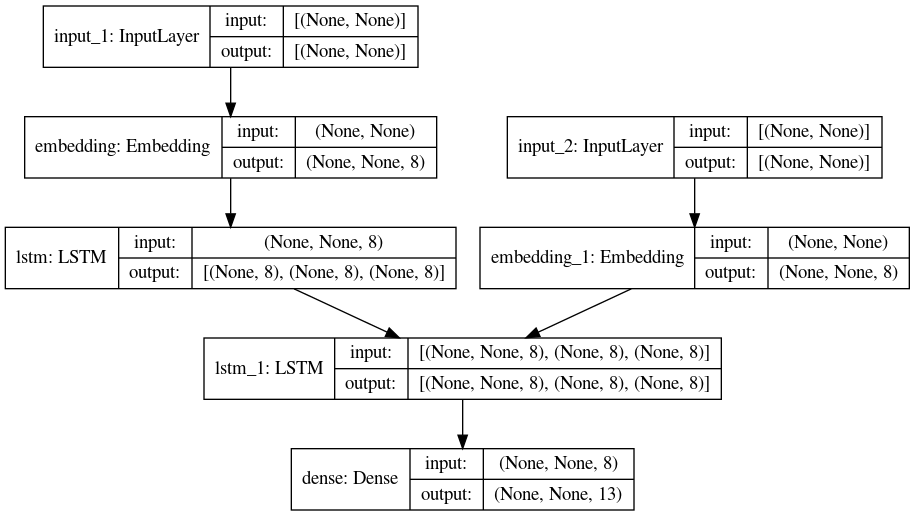

In [14]:
model.summary()
utils.plot_model(model, show_shapes=True, expand_nested=True)

In [15]:
es = callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=1, restore_best_weights=True)
rlp = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1)


history = model.fit_generator(
    generator=generate_batch(X_train, y_train), steps_per_epoch = np.ceil(len(X_train)/config.BATCH_SIZE),
    validation_data=generate_batch(X_valid, y_valid), validation_steps=np.ceil(len(X_valid)/config.BATCH_SIZE),
    epochs=config.MAX_EPOCHS, callbacks=[es, rlp], 
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
5231/5231 [==============================] - 42s 7ms/step - loss: 1.2170 - acc: 0.5923 - val_loss: 0.6605 - val_acc: 0.7374
Epoch 2/25
5231/5231 [==============================] - 37s 7ms/step - loss: 0.6105 - acc: 0.7590 - val_loss: 0.4829 - val_acc: 0.8112
Epoch 3/25
5231/5231 [==============================] - 37s 7ms/step - loss: 0.4572 - acc: 0.8225 - val_loss: 0.4162 - val_acc: 0.8372
Epoch 4/25
5231/5231 [==============================] - 37s 7ms/step - loss: 0.4004 - acc: 0.8457 - val_loss: 0.3648 - val_acc: 0.8635
Epoch 5/25
5231/5231 [==============================] - 37s 7ms/step - loss: 0.3478 - acc: 0.8720 - val_loss: 0.3127 - val_acc: 0.8824
Epoch 6/25
5231/5231 [==============================] - 37s 7ms/step - loss: 0.3007 - acc: 0.8890 - val_loss: 0.2762 - val_acc: 0.8957
Epoch 7/25
5231/5231 [==============================] - 37s 7ms/step - loss: 0.2690 - acc: 0.9003 - val_loss: 0.2496 - val_acc: 0.9090
Epoch 8/25
5231/5231 [==============================] -

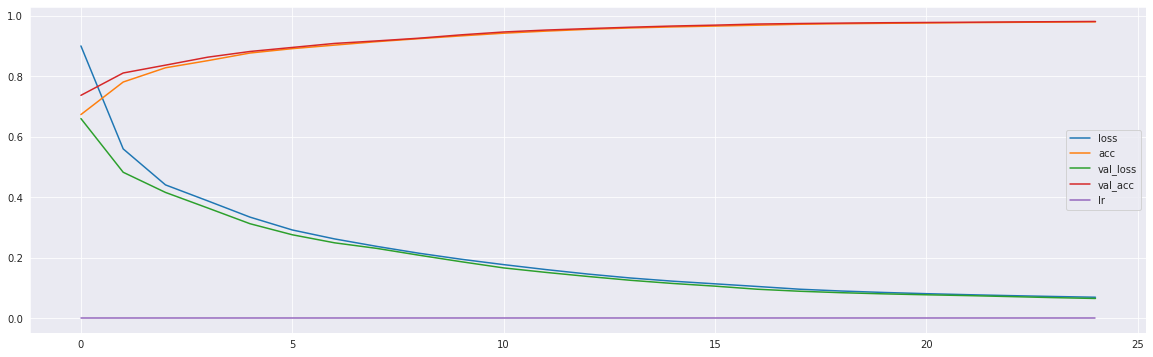

In [16]:
fig, ax = plt.subplots(figsize=(20, 6))
pd.DataFrame(history.history).plot(ax=ax)
del history

# Evaluation

In [17]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(config.LATENT_DIM,))
decoder_state_input_c = Input(shape=(config.LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [18]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_sequence(source):
    states_value = encoder_model.predict(source)
    target_seq = np.ones((1,1))*machine_tokenizer.word_index["@"]
    prediction = []
    for i in range(13):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        token_index = np.argmax(output_tokens[0, -1, :])
#         print(token_index)
        prediction.append(token_index)
        target_seq[0, 0] = token_index
        states_value = [h, c]
        
    return decode_sequence(machine_tokenizer, prediction)

def decode_sequence(tokenizer, source):
    target = list()
    for i in source:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ''.join(target)

In [19]:
query_idx = 19

print('SOURCE     :', decode_sequence(human_tokenizer, np.squeeze(X[query_idx:query_idx+1])))
print('TARGET     :', decode_sequence(machine_tokenizer, np.squeeze(y[query_idx:query_idx+1])))
print('PREDICTION :', predict_sequence(X[query_idx:query_idx+1]))

SOURCE     : 25 jan 2018
TARGET     : @2018-01-25
PREDICTION : 2018-01-25


In [20]:
query_text = 'saturday 19 september 1998'
query = np.array(list(map(lambda x: preprocess_input(x, human_tokenizer, config.X_LEN), [query_text])))

print('SOURCE     :', query_text)
print('PREDICTION :', predict_sequence(query))

SOURCE     : saturday 19 september 1998
PREDICTION : 1998-09-19
